# Data analysis

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# INDICATOR = ['quintilAlfabetizacao','quintilRenda']
# INDICATOR_PRED = ['quintilAlfabetizacaoPred','quintilRendaPred']
# INDICATOR_TITLE= ['Literacy', 'Income']
# FOLDER = ['literacy','income']
INDICATOR = ['quintilRenda']
INDICATOR_PRED = ['quintilRendaPred']
INDICATOR_TITLE= ['Income']
FOLDER = ['incomegpu']

## Distribution of socioeconomic indicators per census sectors

In [10]:
for FOLD in range(0,5):
    df = pd.read_csv(f'{FOLDER[s]}/folds/{FOLD}.csv', usecols=['filename','setor','fold'], low_memory=False)
    df.to_csv(f'{FOLDER[s]}/folds/{FOLD}_clean.csv', sep=';')
    print(df.shape)

(22150, 3)
(22582, 3)
(22278, 3)
(22214, 3)
(21950, 3)


In [17]:
geo = gpd.read_file('raw_data/shapefiles/vale_ribeira.dbf')
df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)
df = pd.merge(df, geo, left_on='setor', right_on='CD_GEOCODI', how='left')
  

pred = df.groupby('setor', as_index=False, group_keys=False).agg(
{'geometry': lambda x: x.tolist()[0], INDICATOR_PRED[s]: lambda x: int(x.mean())})
pred

,setor,geometry,quintilRendaPred
0,3.502705e+14,"POLYGON ((-48.84580 -24.51313, -48.84650 -24.5...",5
1,3.502705e+14,"POLYGON ((-48.84489 -24.51740, -48.84509 -24.5...",4
2,3.502705e+14,"POLYGON ((-48.85038 -24.52333, -48.85048 -24.5...",4
3,3.502705e+14,"POLYGON ((-48.84511 -24.52691, -48.85691 -24.5...",4
4,3.502705e+14,"POLYGON ((-48.84589 -24.51157, -48.84659 -24.5...",5
...,...,...,...
495,4.128633e+14,"POLYGON ((-49.31758 -24.72328, -49.31496 -24.7...",2
496,4.128633e+14,"POLYGON ((-49.39916 -24.70718, -49.35284 -24.6...",3
497,4.128633e+14,"POLYGON ((-49.37073 -24.61246, -49.36844 -24.6...",3
498,4.128633e+14,"POLYGON ((-49.46065 -24.62345, -49.46026 -24.6...",2


### Number of street images used for training

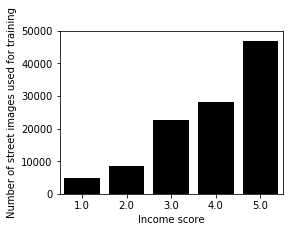

In [3]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/fold-{FOLD}.csv', 
                            usecols=['filename','latitude','longitude','setor','fold',INDICATOR[s]])
                for FOLD in range(0,5)], ignore_index=True)  
    df['photos'] = df['filename'].notna().astype(int)        
    ds = pd.DataFrame(df.groupby(INDICATOR[s])['photos'].sum().reset_index())
    df_new = ds.rename(columns={INDICATOR[s]: INDICATOR_TITLE[s]})
    #display(df_new)
    
    plt.figure(figsize=(4,3))    
    ax= sns.barplot(x= df_new[INDICATOR_TITLE[s]], y=df_new['photos'], color = 'black')
    #plt.title(INDICATOR_TITLE[s])    
    
    ax.set(xlabel=INDICATOR_TITLE[s] + ' score', ylabel='Number of street images used for training')
    ax.set(ylim=(0, 50000))
    plt.show()

In [4]:
display(df_new)

display(df_new['photos'].sum())

,Income,photos
0,1.0,4828
1,2.0,8372
2,3.0,22688
3,4.0,28196
4,5.0,46740


110824

### Number of street images for prediction

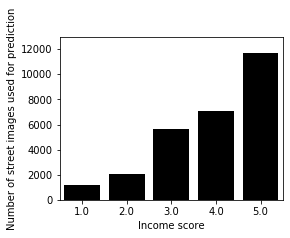

In [5]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)  
    df['photos'] = df['setor'].notna().astype(int)        
    ds = pd.DataFrame(df.groupby(INDICATOR[s])['photos'].sum().reset_index())
    df_new = ds.rename(columns={INDICATOR[s]: INDICATOR_TITLE[s]})
    #display(df_new)
    
    plt.figure(figsize=(4,3))    
    ax= sns.barplot(x= df_new[INDICATOR_TITLE[s]], y=df_new['photos'], color = 'black')
    #plt.title(INDICATOR_TITLE[s])    
    
    ax.set(xlabel=INDICATOR_TITLE[s] + ' score', ylabel='Number of street images used for prediction')
    ax.set(ylim=(0, 13000))
    plt.show()

In [6]:
display(df_new)

display(df_new['photos'].sum())

,Income,photos
0,1.0,1207
1,2.0,2093
2,3.0,5672
3,4.0,7049
4,5.0,11685


27706

## Street view images

In [22]:
from PIL import Image
from urllib.parse import urlencode
import random
import requests
from tqdm import tqdm 

import numpy as np
np.random.seed(286571) #seed random generator for reproduciblity

In [23]:
def get_image(pano_id, direction):
    y_ = []
    for y in range(2):
        params = {
            "cb_client": "maps_sv.tactile",
            "authuser": 0,
            "hl": "en",
            "gl": "br",
            "x": direction // 90,
            "y": y,
            "zoom": 2,
            "nbt": None,
            "fover": 0,
            "output": "tile",
            "panoid": pano_id,
        }
        url = f"https://geo{np.random.randint(0, 3)}.ggpht.com/cbk?{urlencode(params)}"
        img = np.asarray(Image.open(requests.get(url, stream=True).raw))
        y_.append(img[256:, :, :] if y == 0 else img[:256, :, :])
    return np.concatenate(y_)

def plot_image(score, w,h):
    _, axs = plt.subplots(w, h, figsize=(5,5))
    plt.suptitle(f'Samples for {INDICATOR_TITLE[s]} with score = {score}')      

    sample = ds[ds[INDICATOR[s]] == score].sample(w*h)
    for i in tqdm(range(0,w * h), leave=False):            
        row = sample.iloc[i]        
        axs[i%w][i//h].imshow(get_image(row['pano_id'], row['direction']))

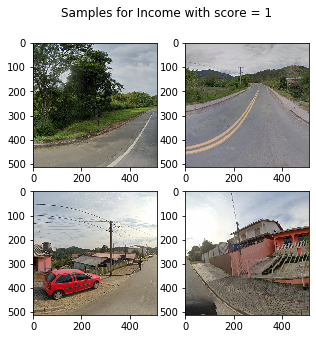

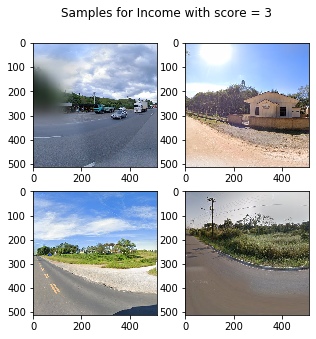

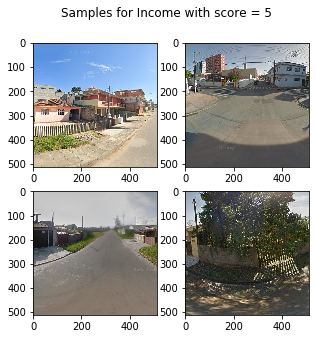

In [10]:
for s in range(0,len(INDICATOR)):
    df = pd.read_csv('geo_fold.csv') 
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv')
    ds = pd.merge(df, idh, left_on='setor', right_on='Cod_setor', how='inner')
    
    plot_image(score=1, w=2,h=2)
    plot_image(score=3, w=2,h=2)
    plot_image(score=5, w=2,h=2)         
         

### Saving images samples

In [11]:
for s in range(0,len(INDICATOR)):
    df = pd.read_csv('geo_fold.csv')
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv', usecols=['Cod_setor', INDICATOR[s]]) 
    #df = pd.read_csv('geo.csv')
    ds = pd.merge(df, idh, left_on='setor', right_on='Cod_setor', how='inner')


    for score in range(1, 5+1):            
        num_samples=6
        rand_samples =np.random.randint(200, size=num_samples) #4 samples
        sample = ds[ds[INDICATOR[s]] == score].sample(200)
        for c in range(0, num_samples):
            row = sample.iloc[rand_samples[c]]
            while True:
                try:                    
                    fig, axs = plt.subplots(1, 1, figsize=(10,10))
                    plt.imshow(get_image(row['pano_id'], row['direction']))
                    #plt.suptitle(f'Score {score}')
                    axs.axes.get_xaxis().set_visible(False)
                    axs.axes.get_yaxis().set_visible(False)
                    axs.set_aspect('equal')
                    break
                except OSError:
                    continue
                    
            plt.savefig(f'{FOLDER[s]}/score_images/{INDICATOR_TITLE[s]}-score-{score}-sample-{c+4}.png')
            plt.close()

# Prediction performance

## Socioeconomic indicators

In [12]:
for s in range(0,len(INDICATOR)):
    data = {f'fold {i}':{} for i in range(0,5)} 
    for i in range(0,5):#    
        for error in range(2): #'±0', '±1', '±2'            
            pred_fold = pd.read_csv(f'{FOLDER[s]}/folds/pred-{i}.csv')
            data[f'fold {i}'][error] = ((pred_fold[INDICATOR[s]]-pred_fold[INDICATOR_PRED[s]]).abs() <= error).astype(int).mean()
    r = pd.DataFrame(data)    
    r.index = ['±0', '±1']
    r.index.name = 'Margin'   
    print(INDICATOR_TITLE[s] + ' score')
    display(r)

Income score


,fold 0,fold 1,fold 2,fold 3,fold 4
Margin,,,,,
±0,0.534239,0.551173,0.562860,0.565932,0.556490
±1,0.778623,0.795131,0.801693,0.811777,0.814077


## Confusion matrix

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import display

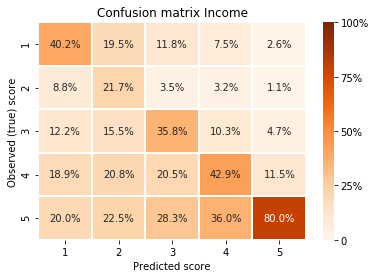

In [14]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)
    
    cf = confusion_matrix(df[INDICATOR[s]], df[INDICATOR_PRED[s]])

    plt.figure(figsize=(6,4))
    ax=sns.heatmap((cf.T/cf.sum(axis=1)), xticklabels=range(1,5+1),yticklabels=range(1,5+1),
                annot=True, 
                fmt='.1%', cmap='Oranges',
                vmin=0, vmax=1,
               linewidths=1)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
    plt.title("Confusion matrix "+ INDICATOR_TITLE[s])
    plt.xlabel('Predicted score')
    plt.ylabel('Observed (true) score')    
    plt.savefig(fname=f'plots/confmatrix-{INDICATOR_TITLE[s]}.pdf', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')
    plt.savefig(fname=f'plots/confmatrix-{INDICATOR_TITLE[s]}.png', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')


In [15]:
cf.sum(axis=1).sum(axis=0)*4

110824

## Vale do Ribeira geomap prediction

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

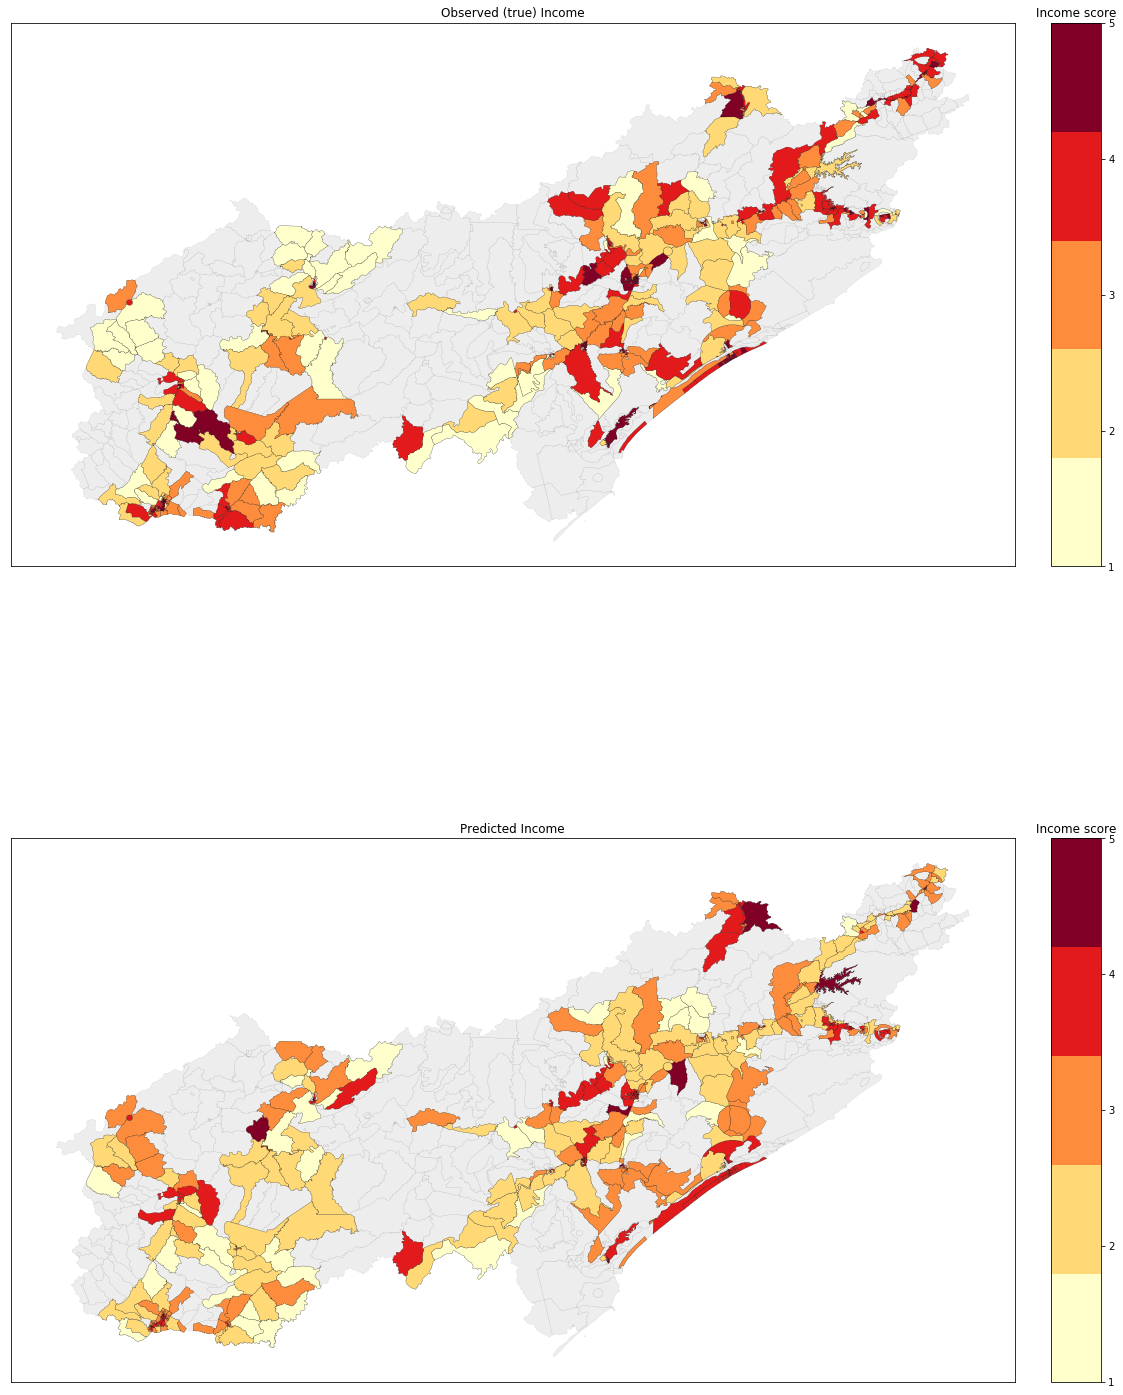

In [17]:
geo = gpd.read_file('raw_data/shapefiles/vale_ribeira.dbf')
df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)
df = pd.merge(df, geo, left_on='setor', right_on='CD_GEOCODI', how='left')

real = df.groupby('setor', as_index=False, group_keys=False).agg(
    {'geometry': lambda x: x.tolist()[0], INDICATOR[s]: lambda x: int(x.mean())})

g_real=gpd.GeoDataFrame(real)#Convert Pandas DataFrame to GeoPandas DataFrame    

pred = df.groupby('setor', as_index=False, group_keys=False).agg(
{'geometry': lambda x: x.tolist()[0], INDICATOR_PRED[s]: lambda x: int(x.mean())})
g_pred=gpd.GeoDataFrame(pred)

# -- configuring fancy plots params --- 
missing_kwds={"color": "lightgrey",
              "label": "Missing values",
             "linewidth":0.5}
#"edgecolor": "black",#"hatch": "...", "hatch":"///"

cmap = plt.cm.get_cmap('YlOrRd', 5)    # 5 discrete colors
    
fig, axs = plt.subplots(2, 1, figsize=(20*5,5*5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

def plot_colorbar(axes):    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=5))
    sm._A = []
    divider = make_axes_locatable(axes=axes)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cbar = fig.colorbar(sm, cax=cax,  ticks=[1,2,3,4,5])
    cbar.ax.set_title('Income score')

    
#---- 1st subplot ---- 
axs[0].set_title(f'Observed (true) {INDICATOR_TITLE[s]}')     

# Introduce some missing values:
#g_real.loc[np.random.choice(g_real.index, 120), INDICATOR[s]] = np.nan
geo.plot(color= 'lightgray',alpha=0.4, edgecolor='black', ax=axs[0], linewidth=0.1) #contourn
g_real.plot(column=INDICATOR[s], ax=axs[0], cmap=cmap,linewidth=0.2,edgecolor='black', missing_kwds=missing_kwds)#color-fill

#axs[0].set_axis_off()
axs[0].axes.get_xaxis().set_visible(False)
axs[0].axes.get_yaxis().set_visible(False)
axs[0].set_aspect('equal')
plot_colorbar(axs[0])


#---- 2nd subplot ----     
axs[1].set_title(f'Predicted {INDICATOR_TITLE[s]}')#RdBu

# Introduce some missing values:
#g_pred.loc[np.random.choice(g_pred.index, 120), INDICATOR_PRED[s]] = np.nan

geo.plot(color= 'lightgray',alpha=0.4, edgecolor='black', ax=axs[1], linewidth=0.1)#contourn
g_pred.plot(column=INDICATOR_PRED[s], ax=axs[1],cmap=cmap,linewidth=0.2,edgecolor='black', missing_kwds=missing_kwds)#color-fill
#geo.boundary.plot
#axs[1].set_axis_off()
axs[1].axes.get_xaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[1].set_aspect('equal')
plot_colorbar(axs[1])


plt.savefig(fname='plots/map_prediction.pdf', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')
plt.savefig(fname='plots/map_prediction.png', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')
#plt.show() 


In [18]:
city_codes = {
    'PARIQUERA-AÇU': 3536208,
    'RIBEIRA': 3542800,
    'ITAÓCA': 3522158,
    'CANANÉIA': 3509908,
    'ELDORADO': 3514809,
    'IGUAPE': 3520301,
    'ILHA COMPRIDA': 3520426,
    'JACUPIRANGA': 3524600,
    'IPORANGA': 3521200,
    'JUQUIÁ': 3526100,
    'ITARIRI': 3523305,
    'JUQUITIBA': 3526209,
    'ITAPIRAPUÃ PAULISTA': 3522653,
    'MIRACATU': 3529906,
    'TAPIRAÍ': 3553500,
    'SÃO LOURENÇO DA SERRA': 3549953,
    'REGISTRO': 3542602,
    'SETE BARRAS': 3551801,
    'PEDRO DE TOLEDO': 3537206,
    'CAJATI': 3509254,
    'CERRO AZUL': 4105201,
    'ITAPERUÇU': 4111258,
    'BOCAIÚVA DO SUL': 4103107,
    'TUNAS DO PARANÁ': 4127882,
    'RIO BRANCO DO SUL': 4122206,
    'BARRA DO TURVO': 3505401,
    'APIAÍ': 3502705,
    'BARRA DO CHAPÉU': 3505351,
    'DOUTOR ULYSSES': 4128633,
    'ADRIANÓPOLIS': 4100202
}


# Plots

In [19]:
from shapely.geometry import Point, Polygon

vr = gpd.read_file('raw_data/shapefiles/censo2010_municipios_valeRibeira/valedaRibeira_merged.dbf')

geo = pd.read_csv('geo.csv') 
df = geo[geo['pano_id'] != 'pano_id']
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df = df.drop_duplicates(subset=['pano_id', 'direction'])
df = df[(df['latitude'] < 10)&(df['longitude'] > -75)&(df['longitude'] < -25)]
geometry = [Point(xy) for xy in zip(df['longitude'].astype(float), df['latitude'].astype(float))]
geo = gpd.GeoDataFrame(df, geometry=geometry)


g_dif = pd.merge(g_real, g_pred[['setor','quintilRendaPred']], on="setor")
g_dif['diff'] = g_dif['quintilRenda'] - g_dif['quintilRendaPred']
g_dif['diff_abs'] = (g_dif['quintilRenda'] - g_dif['quintilRendaPred']).abs()



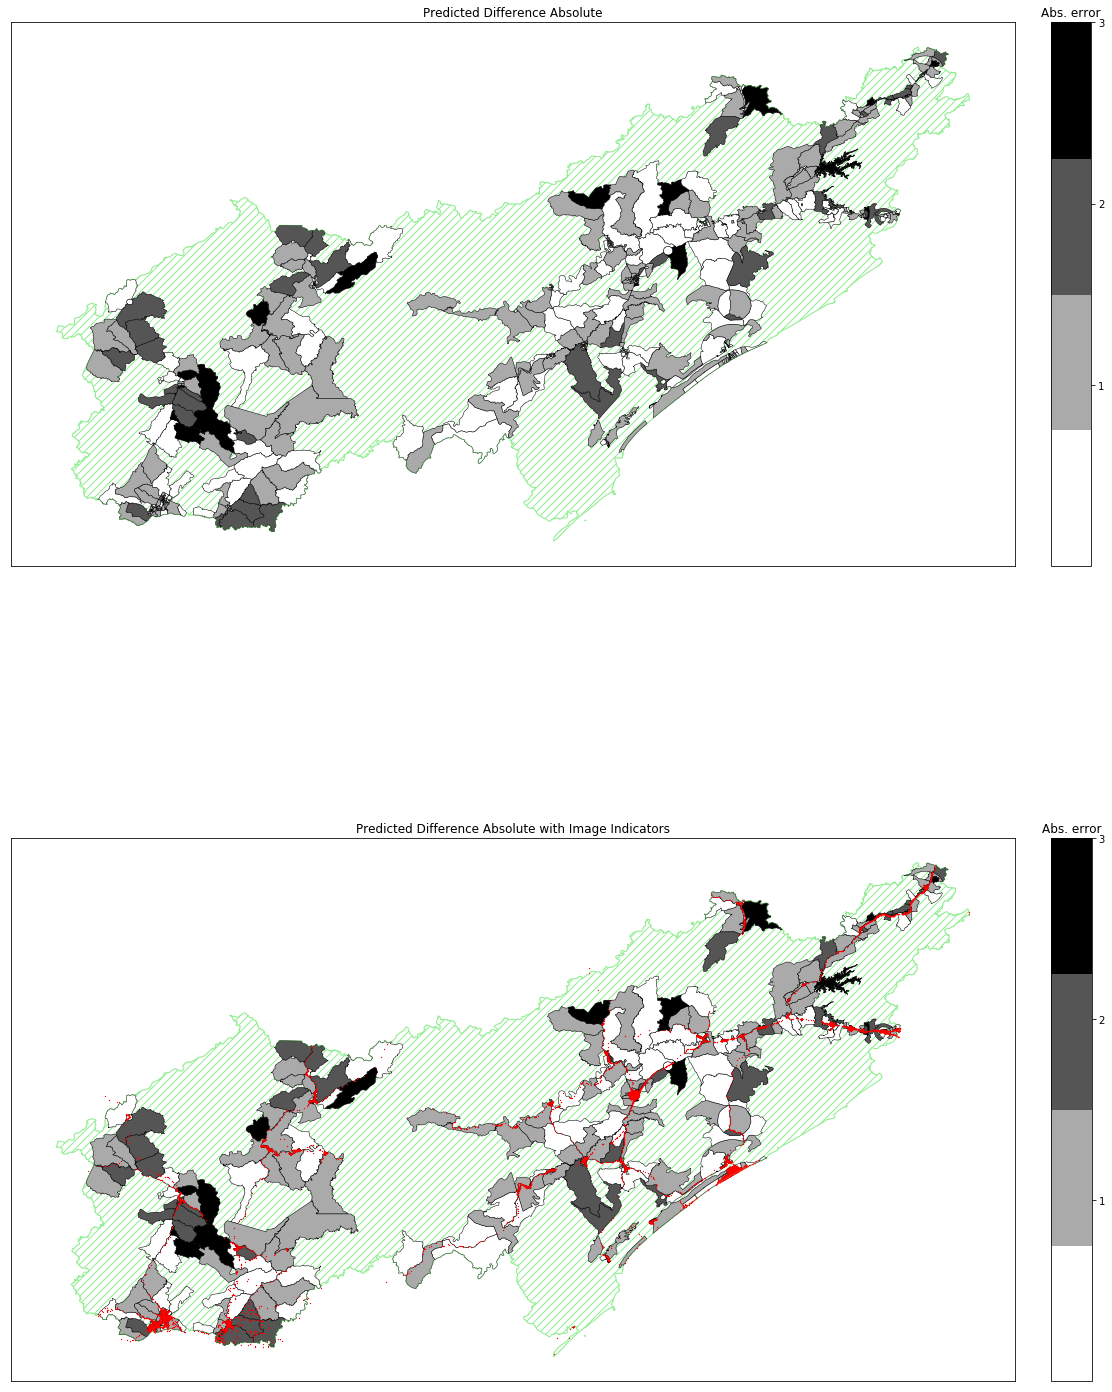

In [20]:

 
missing_kwds={"color": "lightgrey",
              "label": "Missing values",
             "linewidth":0.5}   

my_cmap = plt.cm.get_cmap('gray_r',4)
#my_cmap.set_under(color='orange', alpha=0.5) 

    
fig, axs = plt.subplots(2, 1, figsize=(20*5,5*5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)



def plot_colorbar(axes, cmap_, values, init, end, text):    
    sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.Normalize(vmin=init, vmax=end))
    sm._A = []
    divider = make_axes_locatable(axes=axes)
    cax = divider.append_axes("right", size=str(values)+"%", pad=0.5)
    cbar = fig.colorbar(sm, cax=cax,  ticks=list(range(1, values)))
    cbar.ax.set_title(text)
    
#---- 4th subplot ----     
axs[0].set_title(f'Predicted Difference Absolute')#RdBu

vr.boundary.plot(edgecolor='lightgreen',ax=axs[0], linewidth=0.3,linestyle='dashed') #contourn
vr.plot(cmap= my_cmap, edgecolor='lightgreen',ax=axs[0], hatch="///") #fill
g_dif.plot(column='diff_abs', ax=axs[0],cmap=my_cmap,linewidth=0.5, edgecolor='black',missing_kwds=missing_kwds)#color-fill
plot_colorbar(axs[0],my_cmap,4,0,3,'Abs. error')
axs[0].axes.get_xaxis().set_visible(False)
axs[0].axes.get_yaxis().set_visible(False)
axs[0].set_aspect('equal')

#---- 5th subplot ---- 
axs[1].set_title(f'Predicted Difference Absolute with Image Indicators')

vr.boundary.plot(edgecolor='lightgreen',ax=axs[1], linewidth=0.3,linestyle='dashed') #contourn
vr.plot(cmap= my_cmap, edgecolor='lightgreen',ax=axs[1], hatch="///") #fill
g_dif.plot(column='diff_abs', ax=axs[1],cmap=my_cmap,linewidth=0.5,edgecolor='black', missing_kwds=missing_kwds)#color-fill



for city in geo['city'].unique():
    city_dots = geo[geo['city'] == city]        
    images_plot = city_dots.plot(ax=axs[1], markersize=0.5, color='red',linewidth=0.4) #streets
    
plot_colorbar(axs[1],my_cmap,4,0,3,'Abs. error')  
axs[1].axes.get_xaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[1].set_aspect('equal')







plt.savefig(fname='plots/error_map_prediction.pdf', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')
plt.savefig(fname='plots/error_map_prediction.png', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight')
#plt.show() 

## Figure 4

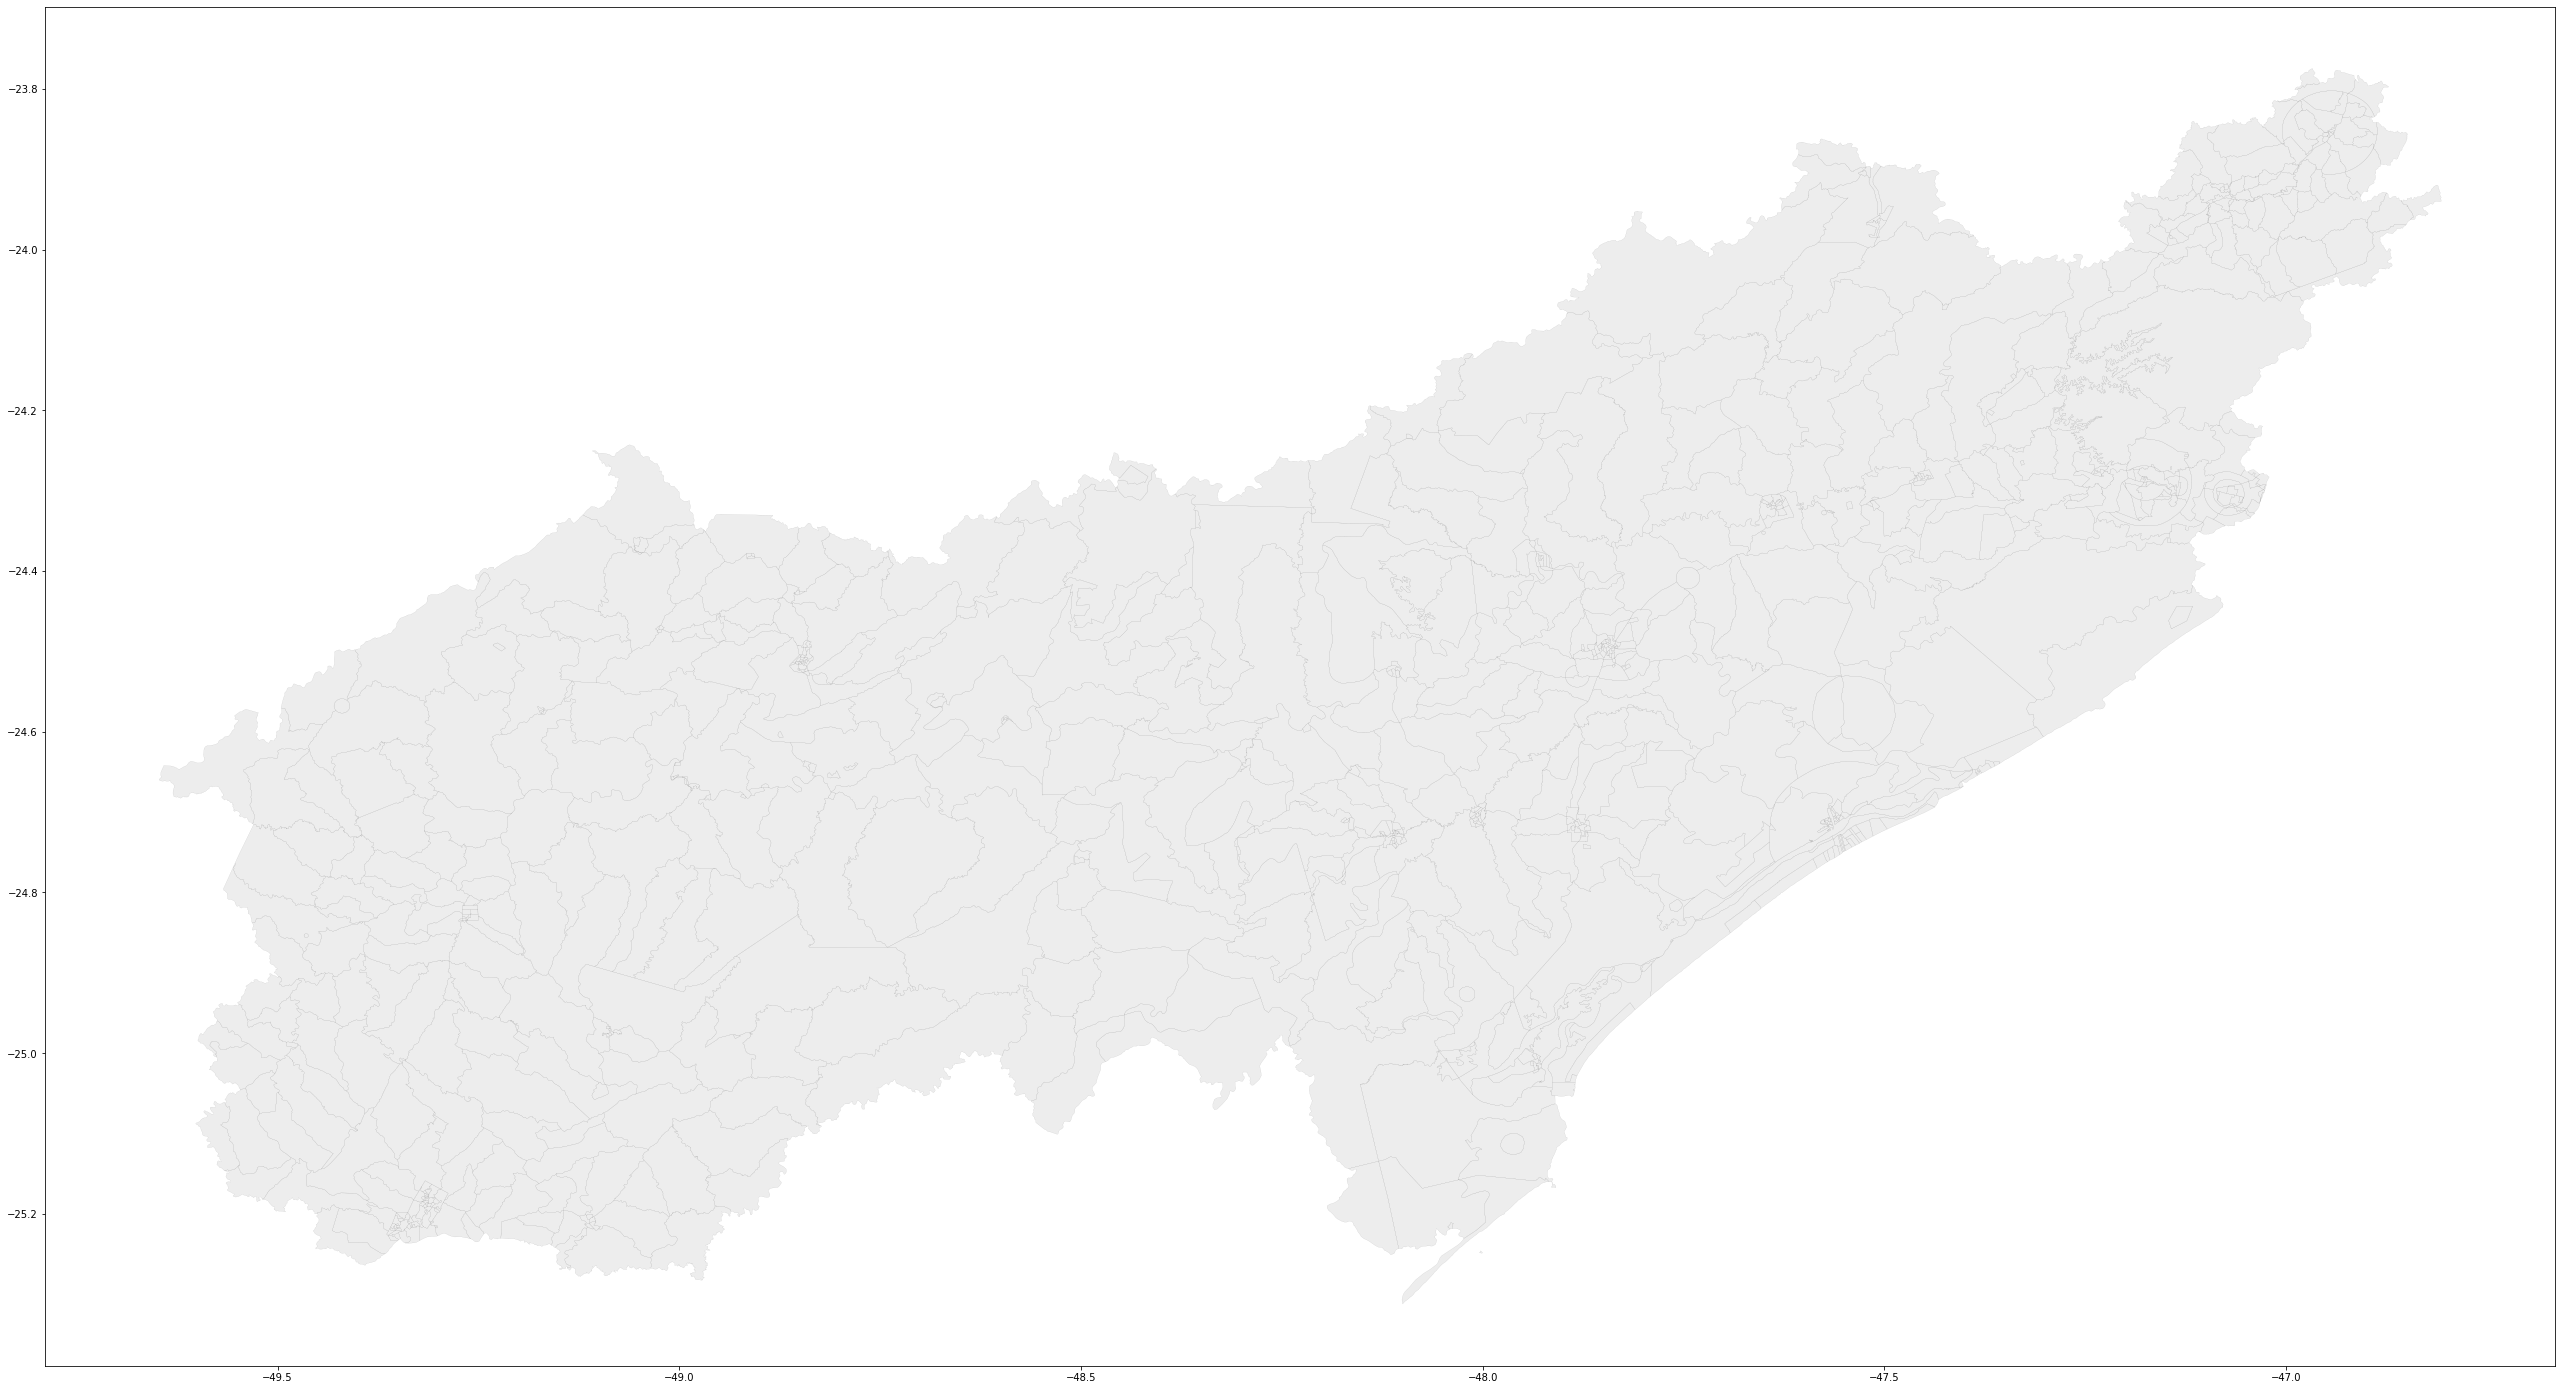

In [18]:
geo = gpd.read_file('raw_data/shapefiles/vale_ribeira.dbf')
    
fig, axs = plt.subplots(1, 1, figsize=(20*5,5*5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
geo.plot(color= 'lightgray',alpha=0.4, edgecolor='black', ax=axs, linewidth=0.1)#contourn

plt.savefig(fname='plots/map_vr.pdf', dpi=300, facecolor='w', edgecolor='w')
plt.show()

In [26]:
def plot_image(score, w,h):
    _, axs = plt.subplots(w, h, figsize=(5,5))
    plt.suptitle(f'Samples for {INDICATOR_TITLE[s]} with score = {score}')      

    df = pd.DataFrame(columns=['city','setor','latitude', 'longitude', 'filename','score'])
    sample = ds[ds[INDICATOR[s]] == score].sample(w*h)
    for i in tqdm(range(0,w * h), leave=False):            
        row = sample.iloc[i] 
        print('Cidade: ',row['city'],' Setor:', row['setor'], ' Lat:', row['latitude'], ' Long:', row['longitude'], ' File:', row['filename'], ' Score:', score)
        df = df.append({'city':row['city'],'setor':row['setor'], 'latitude':row['latitude'], 'longitude': row['longitude'], 'filename':row['filename'],'score':score}, ignore_index=True)
        axs[i%w][i//h].imshow(get_image(row['pano_id'], row['direction']))
    return df

  0%|          | 0/4 [00:00<?, ?it/s]

----- score = 1 -------
Cidade:  RIO BRANCO DO SUL  Setor: 412220605000022.0  Lat: -25.1832921  Long: -49.3184278  File: ADIzoVelh0iR3oCJgueNjg-0.jpg  Score: 1


 25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]

Cidade:  APIAÍ  Setor: 350270505000030.0  Lat: -24.520007233026035  Long: -48.8396404985328  File: ZIf81nclKVX_RuUAWgYelg-90.jpg  Score: 1


 50%|█████     | 2/4 [00:02<00:02,  1.08s/it]

Cidade:  ITARIRI  Setor: 352330510000005.0  Lat: -24.2970810010287  Long: -47.099971406172216  File: YHnHgMWPoIERJQzj4MIHCg-180.jpg  Score: 1


 75%|███████▌  | 3/4 [00:02<00:00,  1.04it/s]

Cidade:  APIAÍ  Setor: 350270505000034.0  Lat: -24.5089467  Long: -48.8113411  File: lcahEBErvdR24-fQ6mAoOQ-0.jpg  Score: 1


  0%|          | 0/4 [00:00<?, ?it/s]        

----- score = 2 -------
Cidade:  RIBEIRA  Setor: 354280005000003.0  Lat: -24.64195577133432  Long: -49.00459402907988  File: sYDBOGmHM6ABnflUSe9qXw-90.jpg  Score: 2


 25%|██▌       | 1/4 [00:01<00:04,  1.48s/it]

Cidade:  JUQUIÁ  Setor: 352610005000009.0  Lat: -24.316790486391874  Long: -47.646537305386715  File: AXNIM-Sde958S_dHQ2b8Rw-270.jpg  Score: 2


 50%|█████     | 2/4 [00:03<00:03,  1.81s/it]

Cidade:  RIO BRANCO DO SUL  Setor: 412220605000052.0  Lat: -25.1723654899489  Long: -49.312407712465706  File: Km9ZKysjr8EaF5dP4D_2Xg-180.jpg  Score: 2


 75%|███████▌  | 3/4 [00:04<00:01,  1.29s/it]

Cidade:  BOCAIÚVA DO SUL  Setor: 410310705000022.0  Lat: -25.22840615896833  Long: -49.122035435640036  File: aRR-_Uqxm3rgkoVA69o7Jg-180.jpg  Score: 2


  0%|          | 0/4 [00:00<?, ?it/s]        

----- score = 3 -------
Cidade:  PARIQUERA-AÇU  Setor: 353620805000014.0  Lat: -24.72526891942981  Long: -47.86557050486657  File: ypi6Vui1egpkfq82joO7LA-90.jpg  Score: 3


 25%|██▌       | 1/4 [00:01<00:03,  1.01s/it]

Cidade:  RIO BRANCO DO SUL  Setor: 412220605000050.0  Lat: -25.1949704  Long: -49.3030097  File: UNHfa8ImcOcNcsM8hhGk7w-90.jpg  Score: 3


 50%|█████     | 2/4 [00:01<00:01,  1.04it/s]

Cidade:  RIO BRANCO DO SUL  Setor: 412220605000051.0  Lat: -25.18428410000001  Long: -49.3191283  File: SlrueAf-lnJ3SMpDvl5OiA-90.jpg  Score: 3


 75%|███████▌  | 3/4 [00:02<00:00,  1.16it/s]

Cidade:  ITAPERUÇU  Setor: 411125805000011.0  Lat: -25.21074058481374  Long: -49.33798816903077  File: rpHkiNDUE0w2hI_VJviBrQ-270.jpg  Score: 3


  0%|          | 0/4 [00:00<?, ?it/s]        

----- score = 4 -------
Cidade:  PEDRO DE TOLEDO  Setor: 353720605000006.0  Lat: -24.27963053734272  Long: -47.23012505714034  File: 2vFC33mmtovMTOk5YCblkw-0.jpg  Score: 4


 25%|██▌       | 1/4 [00:00<00:02,  1.17it/s]

Cidade:  RIO BRANCO DO SUL  Setor: 412220605000003.0  Lat: -25.20486029502915  Long: -49.32509261931246  File: VTyRvHeaaW-Fq1jbemMMog-180.jpg  Score: 4


 50%|█████     | 2/4 [00:01<00:01,  1.35it/s]

Cidade:  ILHA COMPRIDA  Setor: 352042605000013.0  Lat: -24.74088723649036  Long: -47.54915169369133  File: hyvIcp3UV_t5WSX1xUs-rw-180.jpg  Score: 4


 75%|███████▌  | 3/4 [00:03<00:01,  1.13s/it]

Cidade:  RIO BRANCO DO SUL  Setor: 412220605000011.0  Lat: -25.18688460000001  Long: -49.3225844  File: loEau2riKT1olBNpcPktBA-270.jpg  Score: 4


  0%|          | 0/4 [00:00<?, ?it/s]        

----- score = 5 -------
Cidade:  ITAPERUÇU  Setor: 411125805000002.0  Lat: -25.217633686578267  Long: -49.34751037106114  File: 5fLoxJt5sYP61JUo2oq6Vw-180.jpg  Score: 5


 25%|██▌       | 1/4 [00:01<00:05,  1.80s/it]

Cidade:  SETE BARRAS  Setor: 355180105000003.0  Lat: -24.38238940300991  Long: -47.93032176568772  File: fuFU_KiZHK1DmsFODmNRbA-270.jpg  Score: 5


 50%|█████     | 2/4 [00:03<00:03,  1.56s/it]

Cidade:  REGISTRO  Setor: 354260205000020.0  Lat: -24.500675420510426  Long: -47.852765811203106  File: yKALLCh3DNU4Ib-Fh89piw-180.jpg  Score: 5


 75%|███████▌  | 3/4 [00:04<00:01,  1.50s/it]

Cidade:  REGISTRO  Setor: 354260205000021.0  Lat: -24.5077328  Long: -47.8509348  File: LuJmA6yPTGk_Pmadgyeqaw-0.jpg  Score: 5


,city,setor,latitude,longitude,filename,score
0,RIO BRANCO DO SUL,4.122206e+14,-25.183292,-49.318428,ADIzoVelh0iR3oCJgueNjg-0.jpg,1
1,APIAÍ,3.502705e+14,-24.520007,-48.839640,ZIf81nclKVX_RuUAWgYelg-90.jpg,1
2,ITARIRI,3.523305e+14,-24.297081,-47.099971,YHnHgMWPoIERJQzj4MIHCg-180.jpg,1
3,APIAÍ,3.502705e+14,-24.508947,-48.811341,lcahEBErvdR24-fQ6mAoOQ-0.jpg,1
0,RIBEIRA,3.542800e+14,-24.641956,-49.004594,sYDBOGmHM6ABnflUSe9qXw-90.jpg,2
1,JUQUIÁ,3.526100e+14,-24.316790,-47.646537,AXNIM-Sde958S_dHQ2b8Rw-270.jpg,2
2,RIO BRANCO DO SUL,4.122206e+14,-25.172365,-49.312408,Km9ZKysjr8EaF5dP4D_2Xg-180.jpg,2
3,BOCAIÚVA DO SUL,4.103107e+14,-25.228406,-49.122035,aRR-_Uqxm3rgkoVA69o7Jg-180.jpg,2
0,PARIQUERA-AÇU,3.536208e+14,-24.725269,-47.865571,ypi6Vui1egpkfq82joO7LA-90.jpg,3
1,RIO BRANCO DO SUL,4.122206e+14,-25.194970,-49.303010,UNHfa8ImcOcNcsM8hhGk7w-90.jpg,3


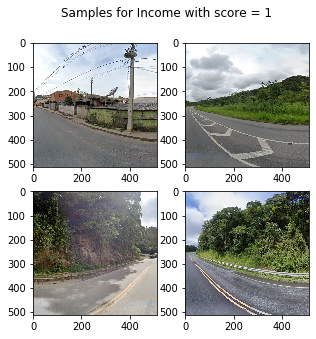

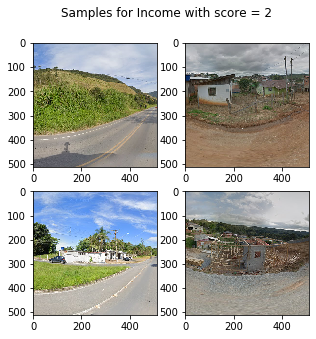

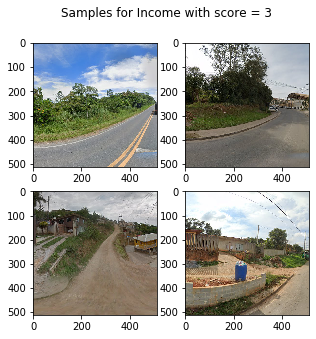

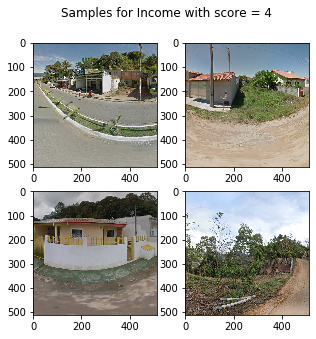

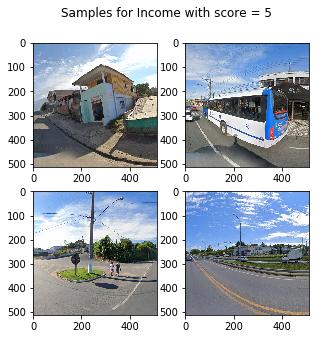

In [27]:
photo_df = pd.DataFrame(columns=['city','setor','latitude', 'longitude', 'filename','score'])
for s in range(0,len(INDICATOR)):
    df = pd.read_csv('geo_fold.csv') 
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv')
    ds = pd.merge(df, idh, left_on='setor', right_on='Cod_setor', how='inner')
    
    print('----- score = 1 -------')
    photo_df = pd.concat([photo_df, plot_image(score=1, w=2,h=2)])
    print('----- score = 2 -------')
    photo_df = pd.concat([photo_df, plot_image(score=2, w=2,h=2)])
    print('----- score = 3 -------')
    photo_df = pd.concat([photo_df, plot_image(score=3, w=2,h=2)])
    print('----- score = 4 -------')
    photo_df = pd.concat([photo_df, plot_image(score=4, w=2,h=2)])
    print('----- score = 5 -------')
    photo_df = pd.concat([photo_df, plot_image(score=5, w=2,h=2)])

photo_df

In [28]:
photo_df

,city,setor,latitude,longitude,filename,score
0,RIO BRANCO DO SUL,4.122206e+14,-25.183292,-49.318428,ADIzoVelh0iR3oCJgueNjg-0.jpg,1
1,APIAÍ,3.502705e+14,-24.520007,-48.839640,ZIf81nclKVX_RuUAWgYelg-90.jpg,1
2,ITARIRI,3.523305e+14,-24.297081,-47.099971,YHnHgMWPoIERJQzj4MIHCg-180.jpg,1
3,APIAÍ,3.502705e+14,-24.508947,-48.811341,lcahEBErvdR24-fQ6mAoOQ-0.jpg,1
0,RIBEIRA,3.542800e+14,-24.641956,-49.004594,sYDBOGmHM6ABnflUSe9qXw-90.jpg,2
1,JUQUIÁ,3.526100e+14,-24.316790,-47.646537,AXNIM-Sde958S_dHQ2b8Rw-270.jpg,2
2,RIO BRANCO DO SUL,4.122206e+14,-25.172365,-49.312408,Km9ZKysjr8EaF5dP4D_2Xg-180.jpg,2
3,BOCAIÚVA DO SUL,4.103107e+14,-25.228406,-49.122035,aRR-_Uqxm3rgkoVA69o7Jg-180.jpg,2
0,PARIQUERA-AÇU,3.536208e+14,-24.725269,-47.865571,ypi6Vui1egpkfq82joO7LA-90.jpg,3
1,RIO BRANCO DO SUL,4.122206e+14,-25.194970,-49.303010,UNHfa8ImcOcNcsM8hhGk7w-90.jpg,3
